0.6613204343105716
0.6217537845657441
0.6402617326958236
0.7121268897322792
0.5578889759992123
0.763999718847938
0.7208761254231227


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.3665546845837999


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.4020765633668859


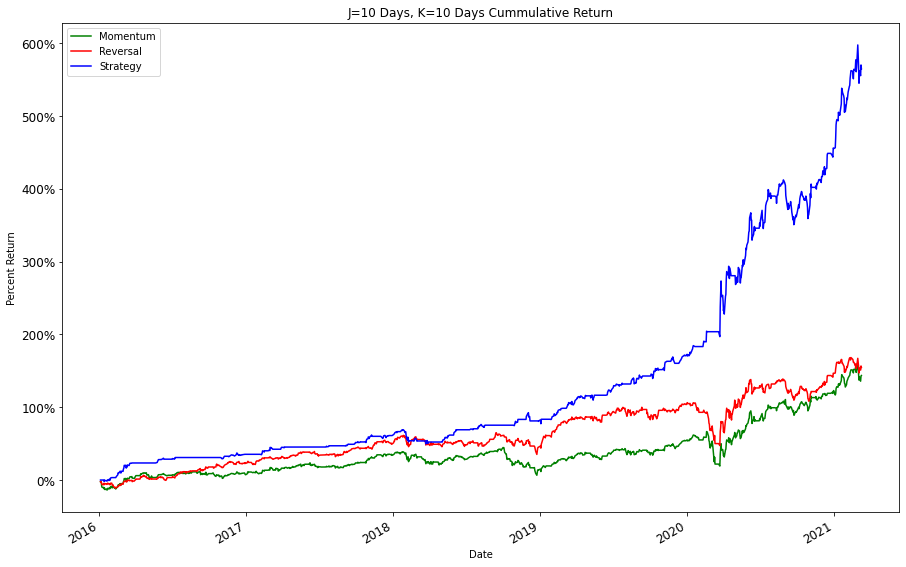

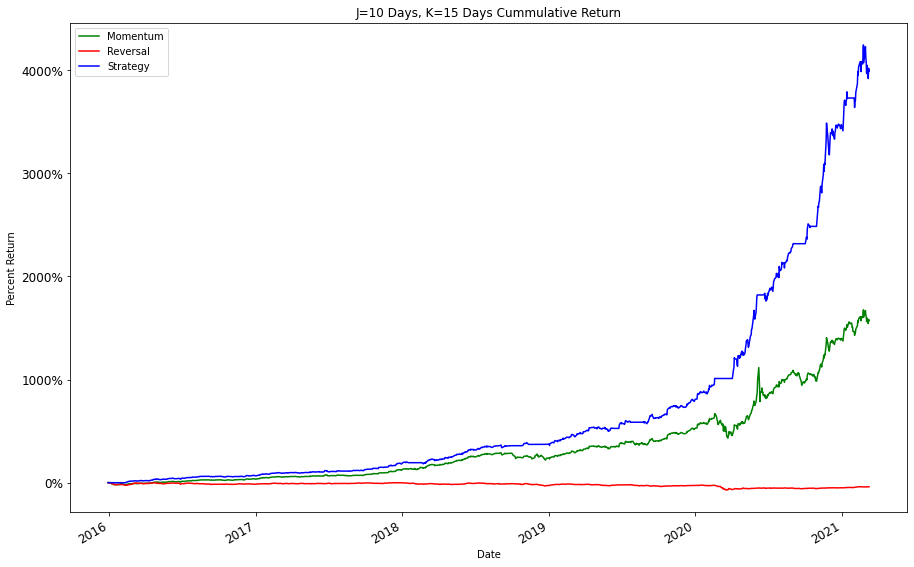

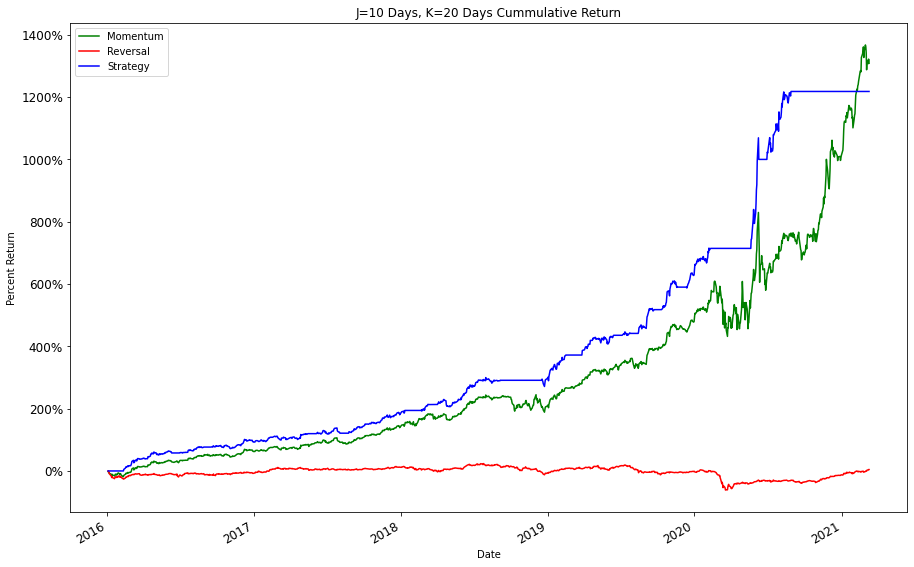

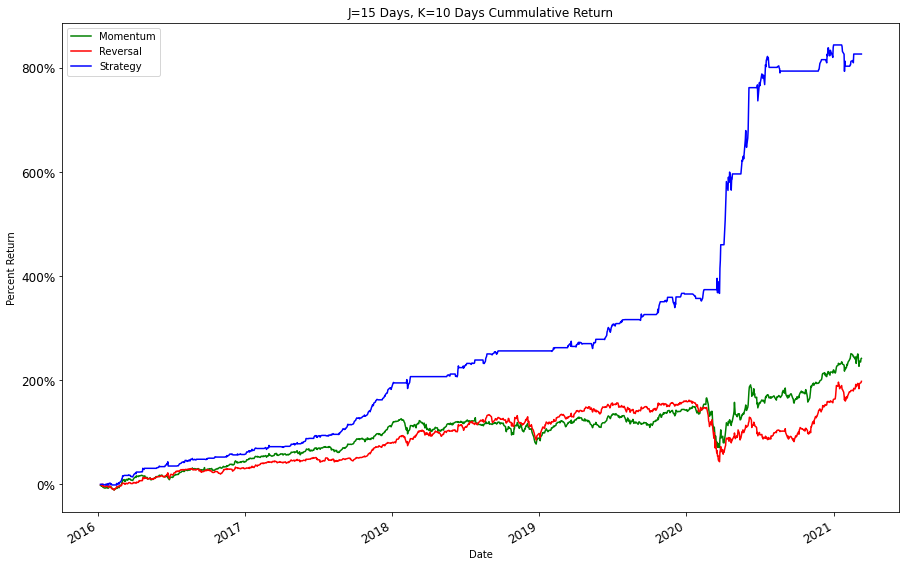

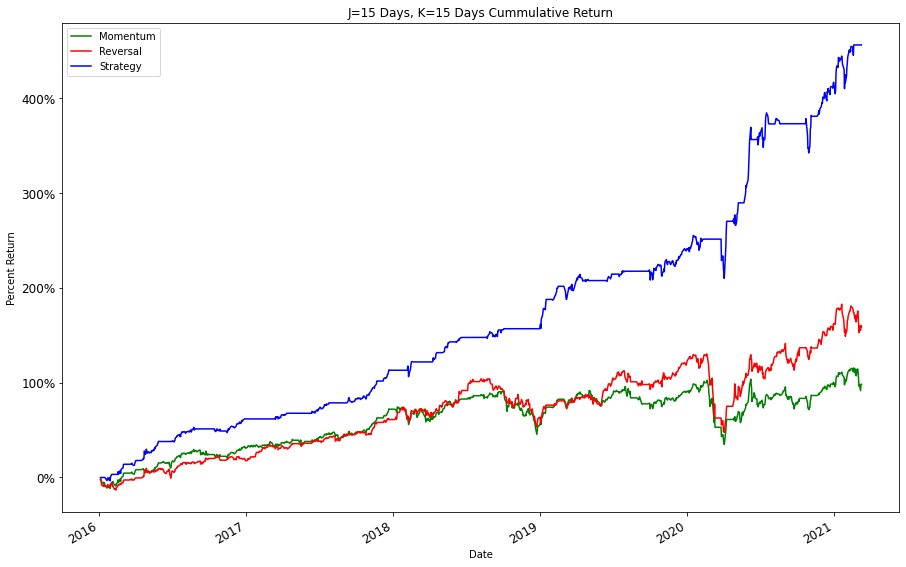

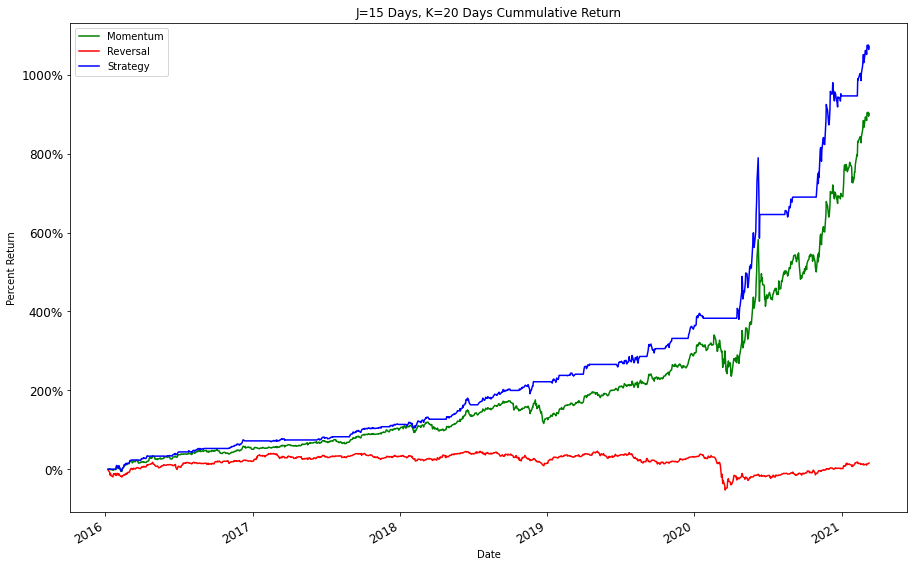

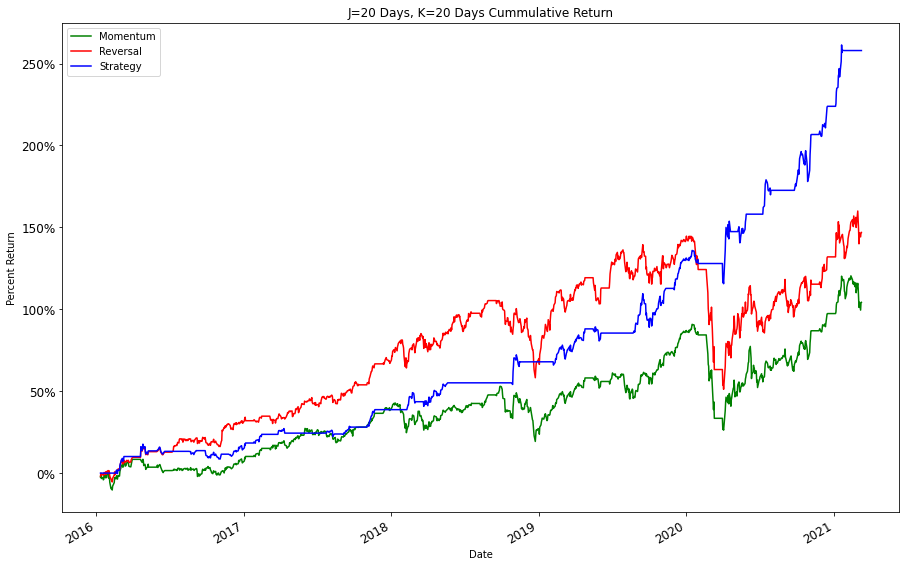

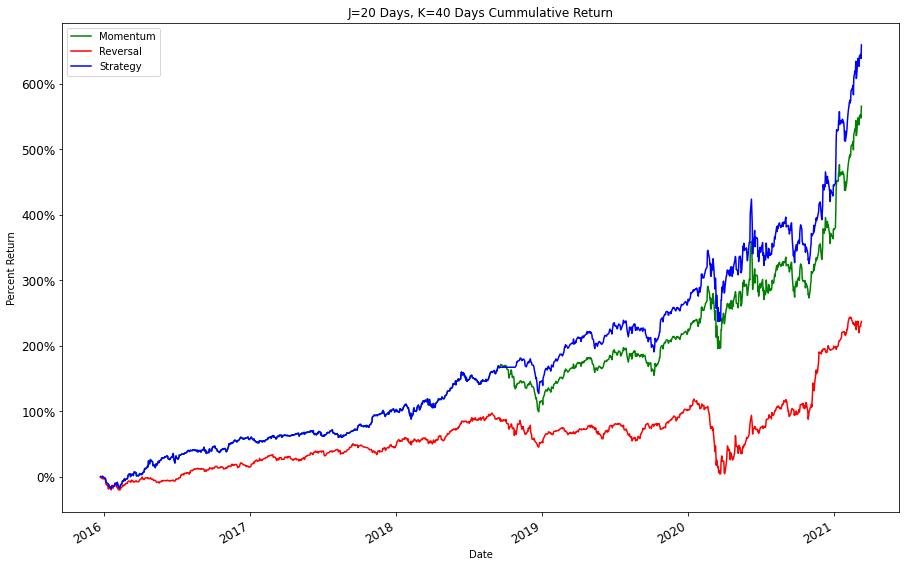

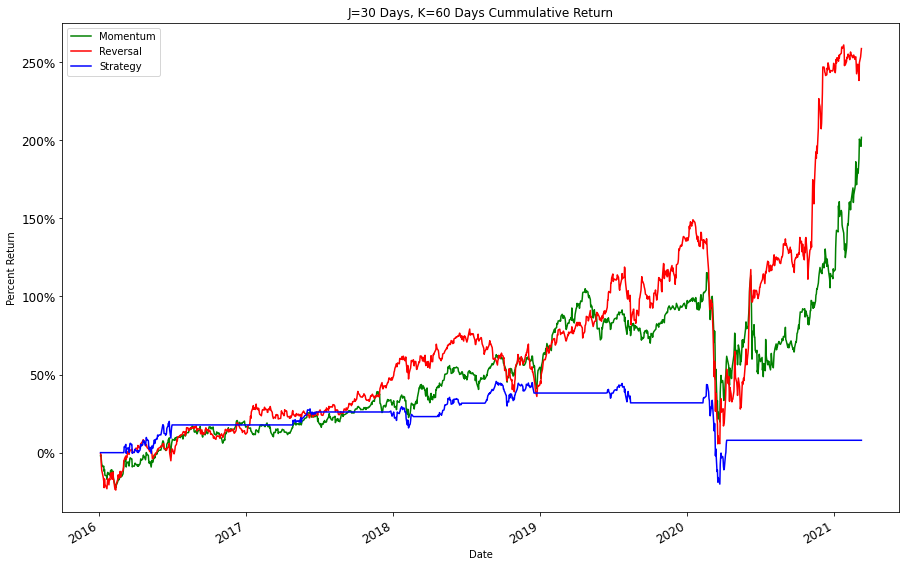

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


results = []
periods = [(10,10),(10,15),(10,20),(15,10),(15,15),(15,20),(20,20),(20,40),(30,60)]


for period in periods:
    
    j = period[0]
    k = period[1]

    features = pd.read_csv('daily_j' + str(j) + '_k' + str(k)+'_features.csv')
    pct = pd.read_csv('daily_j' + str(j) + '_k' + str(k)+'_pct.csv')

    corr = features.corr() 
    #fig, ax = plt.subplots(figsize = (18, 18)) 
    #sns.heatmap(corr[['label']], square=True) 

    correlated_features = set()
    for i in range(len(corr.columns)):
        for a in range(i):
            if abs(corr.iloc[i, a]) > 0.90:
                colname = corr.columns[i]
                correlated_features.add(colname)

    num_colums = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerical_columns = list(features.select_dtypes(include=num_colums).columns)
    df = features[numerical_columns]
    df

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1), 
                                                        df['label'], train_size=0.538,shuffle=False)
    X_before = X_test
    X_train = X_train.dropna()
    X_test = X_test.dropna()

    X_train.drop(columns=correlated_features, axis=1, inplace=True)
    X_test.drop(columns=correlated_features, axis=1, inplace=True)


    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #y_train.hist()

    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
    GridSearchCV(cv=None,
                 estimator=LogisticRegression(C=1.0,intercept_scaling=1,   
                   dual=True, fit_intercept=True, penalty='l2',verbose=False),
                 param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
    clf.fit(X_train,y_train)


    predictions = clf.predict(X_test)
    predictions

    #print(classification_report(y_test,predictions))
    print(f1_score(y_test,predictions,average='weighted'))
    #scores = cross_val_score(clf, X_train, y_train, cv=10)
    #print('Cross-Validation Accuracy Scores', scores)



    X_before['label'] = predictions.tolist()

    performance =pct[['date','index', 'mom_pct_change','rev_pct_change','SP500_pct_change']].infer_objects()
    performance['date'] = pd.to_datetime(performance['date'])
    # output = date.merge(performance, how='right',left_index=True, right_index=True)[['date','index', 'mom_pct_change','rev_pct_change','SP500_pct_change']]
    # output
    # output.to_csv(csv_)
    performance = performance.set_index('date')
    performance = performance.merge(X_before[['label']], left_on='index', right_index=True) #example
    performance['test_pct_change'] = performance.apply(lambda x: x['mom_pct_change'] if x['label']==1 else x['rev_pct_change'] if x['label']==-1 else 0,axis=1) # todo build more models and get their outputs. output results here

    performance[['mom_return','rev_return', 'test_return']] = performance[['mom_pct_change','rev_pct_change', 'test_pct_change']].apply(lambda x: (x+1).cumprod()-1)*100
    #performance[['mom_return','rev_return', 'test_return']] = performance[['mom_pct_change','rev_pct_change', 'test_pct_change']].apply(lambda x: np.log(1 + x).cumsum())

    results.append([j,k,f1_score(y_test,predictions,average='weighted'),predictions,performance['test_return'][-1]])


    import matplotlib.ticker as mtick

    plt = performance[['mom_return','rev_return', 'test_return']].plot(figsize=(15,10),title='J={0} Days, K={1} Days Cummulative Return'.format(j,k),xlabel="Date",ylabel="Percent Return",fontsize=12,color=['green','red','blue'])
    plt.legend(['Momentum','Reversal','Strategy'])
    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    plt.yaxis.set_major_formatter(yticks)
    plt.get_figure().savefig('lr_performance_j{0}_k{1}.png'.format(j,k))




df = pd.DataFrame(results,columns=['j','k','f_score','predictions','test_return']).to_csv('logistic_results.csv')






(10, 10)
(10, 15)
(10, 20)
(15, 10)
(15, 15)
(15, 20)
(20, 20)
(20, 40)
(30, 60)
